In [2]:
import pandas as pd
import xlrd
import boto3
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import re

import random
from collections import defaultdict

import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

import json

In [3]:
s3 = boto3.client('s3')
current_folder = os.getcwd()
sess = sagemaker.Session()
role = get_execution_role()
# Obtiene la ruta local de la carpeta 
local_folder_path = os.path.join(current_folder, 'entreno_final')
print(local_folder_path)

/root/entreno_final/entreno_final


In [4]:
def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = cleaned_text.lower()
    
    return cleaned_text


def preprocess(input_file, output_file, n):
    all_rows = []
    for i in range(n):
        cleaned_text = clean_text(input_file.iloc[i, 0])
        row="__label__" + input_file.iloc[i,1] + " " + cleaned_text
        all_rows.append(row)


    
    with open (output_file ,'w') as f:
        for i in range(len(all_rows)):
            f.write(all_rows[i])
            if i != n-1:
                f.write("\n")
        f.close()

In [5]:
def download_from_s3(bucket_name, s3_file_name, local_file_path):
    try:
        s3.download_file(bucket_name, s3_file_name, local_file_path)
        print("Archivo descargado exitosamente de S3.")
    except FileNotFoundError:
        print("El archivo no se encontró.")
    except NoCredentialsError:
        print("No se encontraron las credenciales de AWS.")

# Especifica el nombre del bucket y el nombre del archivo en S3
bucket_name = 'limpieza-final-and-entreno-final'

# Especifica la ruta local donde deseas guardar el archivo descargado
local_file_path = '/root/entreno_final/dataset.xlsx'

In [6]:
download_from_s3(bucket_name,"DataSetCompleto.xlsx",local_file_path)

Archivo descargado exitosamente de S3.


In [7]:
df=pd.read_excel("dataset.xlsx")
df=df[["Item_Description","ref"]]
df=df.dropna( how="any")
df=df.drop(df[df["ref"]==0].index)

In [8]:
df=df.reset_index(drop=True)

In [9]:
df.head()

,Item_Description,ref
0,"INK RIBBON FOR JRC, MODEL NKG-800; TYPE: #SP-1...",PR19773
1,"SPARE NOZZLE NO.2, FOR NO.1 GAS CUTTING TORCH",PR32252
2,"SPARE CUTTER BLADES 18MM, 6_S/PKT FOR L-500 (S...",PR19498
3,"FLOOD LIGHT FIXTURE LED SLD-150, HIGH BRIGHT 1...",PR45686
4,"COPPER RING KIT 30SIZES/568PCS, IN ACRYL CASE",PR31854


## EMPIEZO PARA EL RESETEO, PROBANDO COSAS NUEVAS

In [11]:
df.shape

(287814, 2)

In [12]:
df_ = df.copy()

In [13]:
label_counts = df_["ref"].value_counts()

# Identificar las etiquetas que aparecen menos de 20 veces
etiquetas_menos_20 = label_counts[label_counts < 20].index

# Filtrar las filas con etiquetas que aparecen menos de 20 veces
df_ = df_[~df_["ref"].isin(etiquetas_menos_20)]

# Eliminar las filas con el carácter "+" en la columna "ref"
df_ = df_[~df_["ref"].str.contains("\\+")]

# Verificar el tamaño del dataframe después de la limpieza
print(df_.shape)

(230037, 2)


In [14]:
df_["Item_Description"] = df_["Item_Description"].str.lower()

# Eliminar caracteres no deseados (excepto letras, números y espacios)
df_["Item_Description"] = df_["Item_Description"].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Sustituir los saltos de línea por una cadena vacía
df_["Item_Description"] = df_["Item_Description"].str.replace('\n', '')

In [15]:
label_counts = df_["ref"].value_counts()

# Identificar las etiquetas raras que aparecen menos de diez veces
rare_labels = label_counts[label_counts < 35].index

# Etiquetar las categorías raras como "PRUNDEF"
df_["ref"] = df_["ref"].apply(lambda x: "PRUNDEF" if x in rare_labels else x)

In [16]:
df_["ref"].value_counts()

PRUNDEF    25624
PR03900     6805
PR07900     3678
PR04700     2785
PR09800     2052
           ...  
PR20315       35
PR17829       35
PR14954       35
PR44946       35
PR17387       35
Name: ref, Length: 1731, dtype: int64

In [17]:
#ANTES DE HACER EL UNDERSAMPLING, SEPARAMOS EL TEST
train, test = train_test_split(df_, test_size=0.05, random_state=0)

In [18]:
test.shape

(11502, 2)

In [19]:
test_csv_path = 'test.csv'
test.to_csv(test_csv_path, index=False)
test_s3_key = 'categoriasraras/solo_/test/test.csv'
s3.upload_file(test_csv_path, bucket_name, test_s3_key)
print(f"Archivo {test_csv_path} cargado en S3 en la carpeta test.")

Archivo test.csv cargado en S3 en la carpeta test.


In [20]:
df_=train.copy()

In [23]:
#indices_dfundef = df_[df_["ref"] == "PRUNDEF"].index
#indices_dfundef_lista = indices_dfundef.tolist()

# Realizar una selección aleatoria de 20,000 índices
#num_muestras_undersampling = 35000
#indices_muestras_seleccionadas = random.sample(indices_dfundef_lista, num_muestras_undersampling)

# Filtrar las filas seleccionadas y las filas que no pertenecen a "DFUNDEF"
#df_ = df_.loc[indices_muestras_seleccionadas + df_[df_["ref"] != "PRUNDEF"].index.tolist()]

In [24]:
df_["ref"].value_counts()

PRUNDEF    24355
PR03900     6479
PR07900     3500
PR04700     2650
PR09800     1952
           ...  
PR17557       31
PR21255       31
PR17770       30
PR45699       30
PR27078       29
Name: ref, Length: 1731, dtype: int64

In [25]:
train, validation = train_test_split(df_, test_size=0.08, random_state=0)

In [26]:
# Crea un cliente de S3
s3 = boto3.client('s3')

# Nombre del bucket
bucket_name = 'limpieza-final-and-entreno-final'

# Rutas locales de los archivos CSV
train_csv_path = 'train.csv'
validation_csv_path = 'validation.csv'


train.to_csv(train_csv_path, index=False)
validation.to_csv(validation_csv_path, index=False)


# Nombres de los archivos en S3 y rutas de destino
train_s3_key = 'categoriasraras/solo_/train/train.csv'
validation_s3_key = 'categoriasraras/solo_/validation/validation.csv'


# Subir archivo de entrenamiento a S3
s3.upload_file(train_csv_path, bucket_name, train_s3_key)
print(f"Archivo {train_csv_path} cargado en S3 en la carpeta train.")

# Subir archivo de validación a S3
s3.upload_file(validation_csv_path, bucket_name, validation_s3_key)
print(f"Archivo {validation_csv_path} cargado en S3 en la carpeta validation.")

Archivo train.csv cargado en S3 en la carpeta train.
Archivo validation.csv cargado en S3 en la carpeta validation.


In [27]:
validation_df=pd.read_csv("s3://limpieza-final-and-entreno-final/categoriasraras/solo_/validation/validation.csv")
validation_df.to_csv("validation.csv")

train_df=pd.read_csv("s3://limpieza-final-and-entreno-final/categoriasraras/solo_/train/train.csv")
train_df.to_csv("train.csv")

test_df=pd.read_csv("s3://limpieza-final-and-entreno-final/categoriasraras/solo_/test/test.csv")
test_df.to_csv("test.csv")

In [28]:
%%time

preprocess(train_df, 'train.train', len(train_df))
        
preprocess(validation_df, 'validation.validation', len(validation_df) )

CPU times: user 12.8 s, sys: 68.7 ms, total: 12.9 s
Wall time: 15.3 s


In [29]:
bucket="limpieza-final-and-entreno-final"
train_channel = 'categoriasraras/solo_/train'
validation_channel = 'categoriasraras/solo_/validation'


sess.upload_data(path='train.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='validation.validation', bucket=bucket, key_prefix=validation_channel)


s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

In [30]:
s3_output_location = 's3://limpieza-final-and-entreno-final/categoriasraras/solo_/output'
region_name = boto3.Session().region_name
print(region_name)
container = sagemaker.image_uris.retrieve( "blazingtext", region_name)
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

eu-central-1
Using SageMaker BlazingText container: 813361260812.dkr.ecr.eu-central-1.amazonaws.com/blazingtext:1 (eu-central-1)


In [31]:
train_input = TrainingInput(s3_train_data, distribution='FullyReplicated', content_type='text/plain')
validation_input = TrainingInput(s3_validation_data, distribution='FullyReplicated', content_type='text/plain')

In [32]:
bt_model = sagemaker.estimator.Estimator(image_uri=container,
                                         role=role, 
                                         instance_count=1, 
                                         instance_type='ml.m4.4xlarge',
                                         volume_size = 50,
                                         max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

bt_model.set_hyperparameters(mode="supervised",
                            epochs=50,
                            min_count=100,
                            learning_rate=0.1,
                            vector_dim=100,
                            early_stopping=True,
                            patience=2,
                            min_epochs=50,
                            word_ngrams=1)

In [33]:
bt_model.fit({'train': train_input, 'validation': validation_input}, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-07-24-09-47-59-553


2023-07-24 09:47:59 Starting - Starting the training job.........
2023-07-24 09:49:14 Starting - Preparing the instances for training...
2023-07-24 09:49:53 Downloading - Downloading input data
2023-07-24 09:49:53 Training - Downloading the training image...
2023-07-24 09:50:29 Training - Training image download completed. Training in progress.....Arguments: train
[07/24/2023 09:50:42 WARNING 140437336737600] Loggers have already been setup.
[07/24/2023 09:50:42 WARNING 140437336737600] Loggers have already been setup.
[07/24/2023 09:50:42 INFO 140437336737600] nvidia-smi took: 0.025304794311523438 secs to identify 0 gpus
[07/24/2023 09:50:42 INFO 140437336737600] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[07/24/2023 09:50:42 INFO 140437336737600] Processing /opt/ml/input/data/train/train.train . File size: 12.796329498291016 MB
[07/24/2023 09:50:42 INFO 140437336737600] Processing /opt/ml/input/data/validation/

In [34]:
predictor = bt_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2023-07-24-09-55-47-632
INFO:sagemaker:Creating endpoint-config with name blazingtext-2023-07-24-09-55-47-632
INFO:sagemaker:Creating endpoint with name blazingtext-2023-07-24-09-55-47-632


----!

In [35]:
print(predictor.endpoint) 

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


blazingtext-2023-07-24-09-55-47-632


In [36]:
lista_test = []
etiquetas_reales = []

for text in test_df["Item_Description"]:
    cleaned_text = re.sub(r'[^\w\s]', '', text).lower()
    cleaned_text = re.sub(r'\n', '', cleaned_text)
    lista_test.append(cleaned_text)
    
for label in test_df["ref"]:
    etiquetas_reales.append("__label__" + label)

In [37]:
payload = {"instances" : lista_test}
response = predictor.predict(json.dumps(payload), initial_args={'ContentType': 'application/json'})
predictions = response.decode("utf-8")
predictions_json = json.loads(predictions)

In [38]:
etiquetas_predichas = []
for prediction in predictions_json:
    etiqueta_predicha = prediction["label"][0]
    etiquetas_predichas.append(etiqueta_predicha)


In [342]:
## PRUEBA CON VARIAS ETIQUETAS
#payload = {"instances": lista_test, "configuration": {"k":2}}
#response = predictor.predict(json.dumps(payload), initial_args={'ContentType': 'application/json'})
#predictions = response.decode("utf-8")
#predictions_json = json.loads(predictions)

#etiquetas_predichas = []
#for prediction in predictions_json:
#    etiquetas = prediction["label"]
#    etiquetas_predichas.append(etiquetas)
    
#etiquetas_predichas_unidas = []
#for prediction in etiquetas_predichas:
#    etiquetas_str = " ".join(prediction)
#    etiquetas_predichas_unidas.append(etiquetas_str)

In [39]:
rara_metrics=pd.read_csv("rara_metrics.csv")

In [40]:
accuracy = accuracy_score(etiquetas_reales, etiquetas_predichas)
recall_macro = recall_score(etiquetas_reales, etiquetas_predichas, average='macro')
f1_macro = f1_score(etiquetas_reales, etiquetas_predichas, average='macro')

recall_micro = recall_score(etiquetas_reales, etiquetas_predichas, average='micro')
f1_micro = f1_score(etiquetas_reales, etiquetas_predichas, average='micro')

recall_we = recall_score(etiquetas_reales, etiquetas_predichas, average='weighted')
f1_we = f1_score(etiquetas_reales, etiquetas_predichas, average='weighted')

print("Accuracy:", accuracy)
print("Recall macro:  ", recall_macro, recall_micro, recall_we)
print("F1-score macro:", f1_macro, f1_micro, f1_we)

metricas = {
    'Accuracy': accuracy,
    'Recall Macro': recall_macro,
    'F1-score Macro': f1_macro,
    'Recall Micro': recall_micro,
    'F1-score Micro': f1_micro,
    'Recall Weighted': recall_we,
    'F1-score Weighted': f1_we,
    'Modelo': 'categoriarara-hasta-20-sinmulitples'
}

rara_metrics=rara_metrics.append(metricas, ignore_index=True)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6918796731003304
Recall macro:   0.6017635714525766 0.6918796731003304 0.6918796731003304
F1-score macro: 0.5866387686178529 0.6918796731003304 0.6787584571397705


In [41]:
rara_metrics.head(20)

,Accuracy,Recall Macro,F1-score Macro,Recall Micro,F1-score Micro,Recall Weighted,F1-score Weighted,Modelo
0,0.654715,0.562750,0.522438,0.654715,0.654715,0.654715,0.644940,categoriarara30-20k
1,0.632479,0.574441,0.519777,0.632479,0.632479,0.632479,0.626592,categoriarara30-15k
2,0.615524,0.571975,0.512932,0.615524,0.615524,0.615524,0.610428,categoriarara30-10k
3,0.660135,0.582701,0.537170,0.660135,0.660135,0.660135,0.652594,categoriarara35-25k
4,0.686123,0.573051,0.544593,0.686123,0.686123,0.686123,0.668933,categoriarara35-25k
5,0.686123,0.573051,0.544593,0.686123,0.686123,0.686123,0.668933,categoriarara35-50k
6,0.682371,0.544494,0.528840,0.682371,0.682371,0.682371,0.659361,categoriarara30-unlimit
7,0.694879,0.561375,0.546019,0.694879,0.694879,0.694879,0.672254,categoriarara35-unlimit
8,0.656660,0.582955,0.535240,0.656660,0.656660,0.656660,0.649818,categoriarara35-25
9,0.645264,0.568185,0.521135,0.645264,0.645264,0.645264,0.637224,categoriarara30-20


In [42]:
rara_metrics.to_csv('rara_metrics.csv', index=False)

In [43]:
sess.delete_endpoint(predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: blazingtext-2023-07-24-09-55-47-632


In [167]:
#for i in range(len(etiquetas_reales)):
#    print("real:" + etiquetas_reales[i] + "pred:"+ etiquetas_predichas[i])

### REPRESENTACIÓN DE LAS 10 CLASES MÁS VISUALIZADAS

#### 35-unlimited

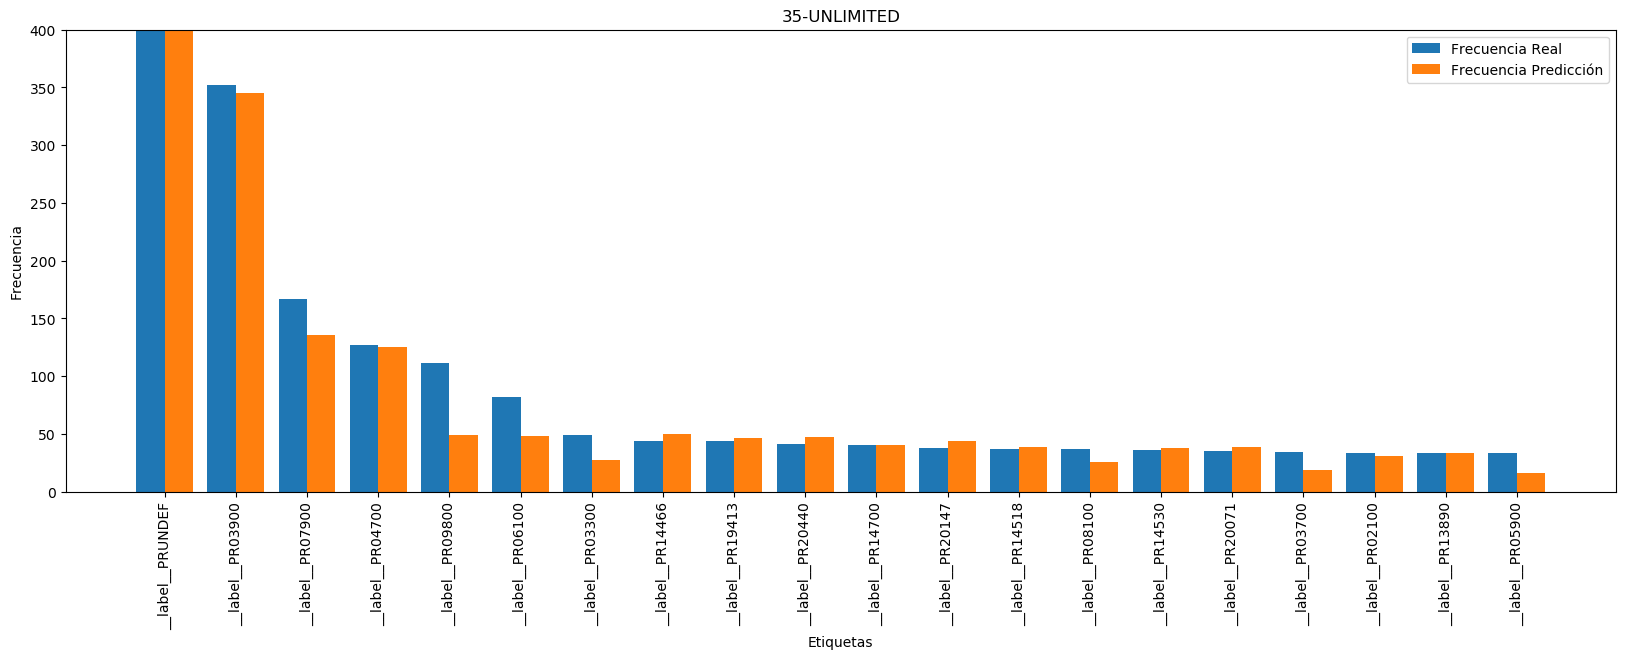

In [177]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:20]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:20]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(20, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('35-UNLIMITED')
plt.ylim(0, 400)
plt.legend()
plt.show()

#### 35- 25k

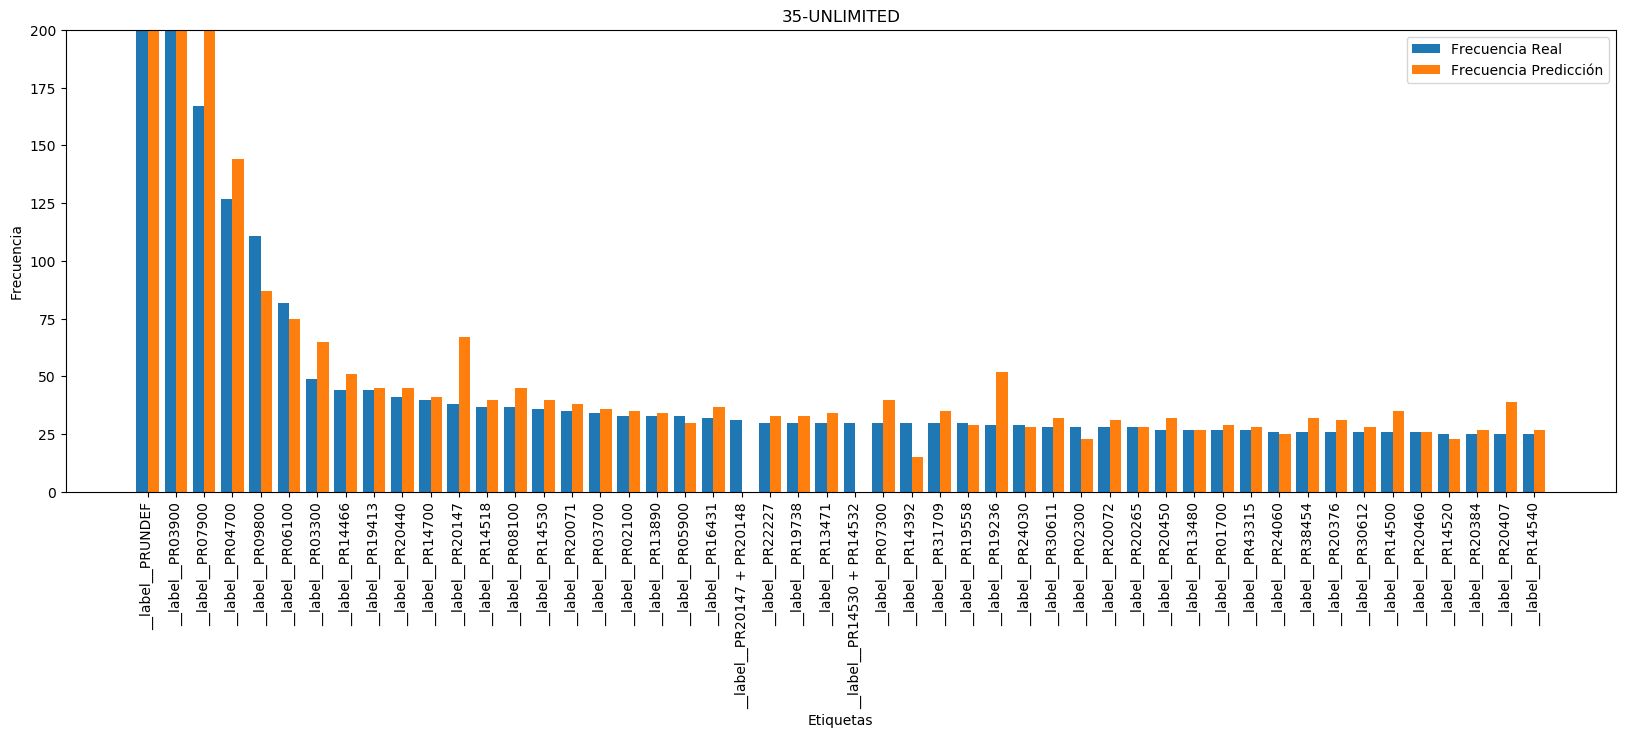

In [209]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(20, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('35-UNLIMITED')
plt.ylim(0, 200)
plt.legend()
plt.show()

#### 30-15

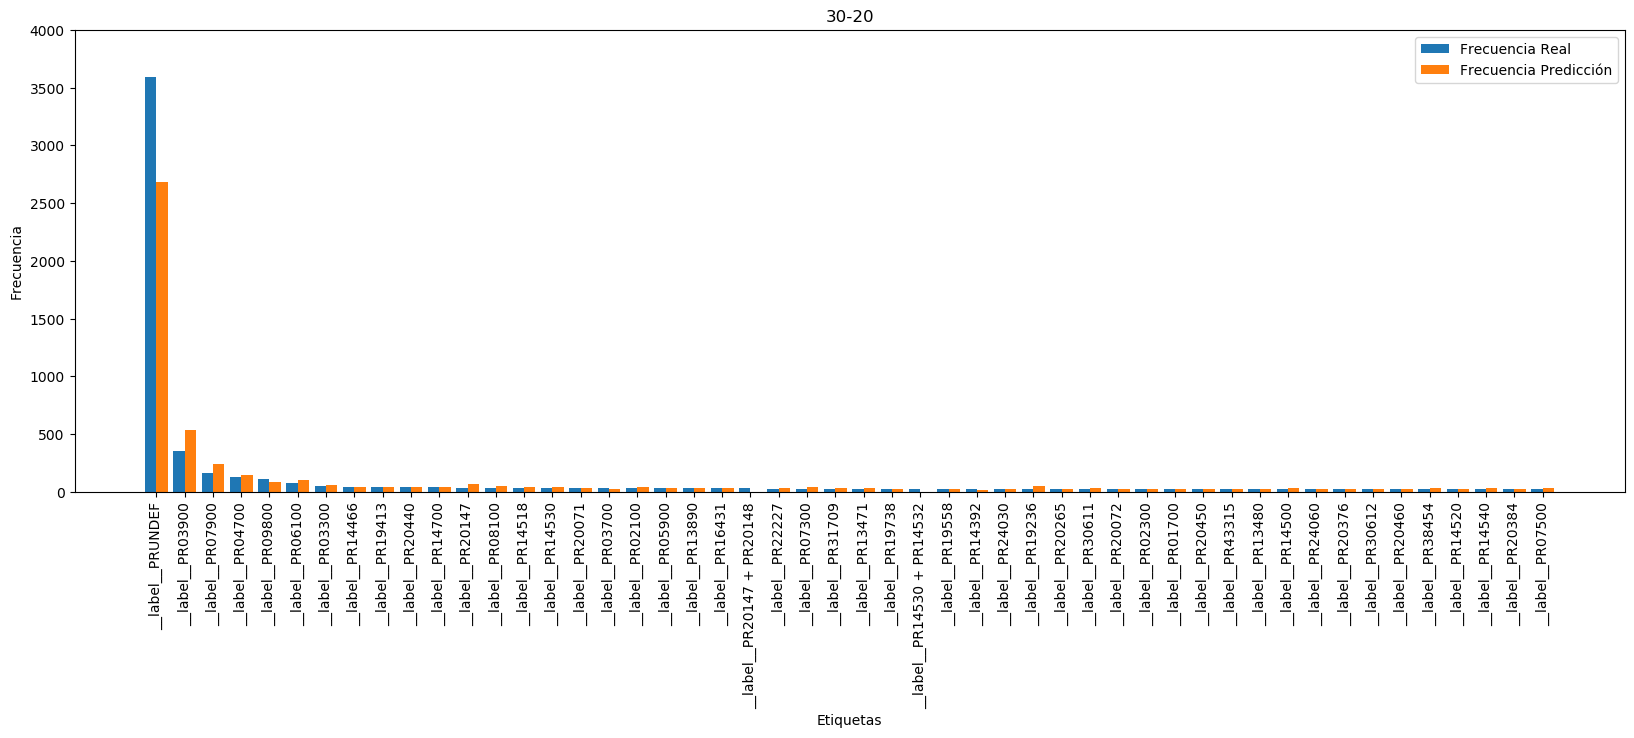

In [243]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(20, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('30-20')
plt.ylim(0, 4000)
plt.legend()
plt.show()

#### 30-30

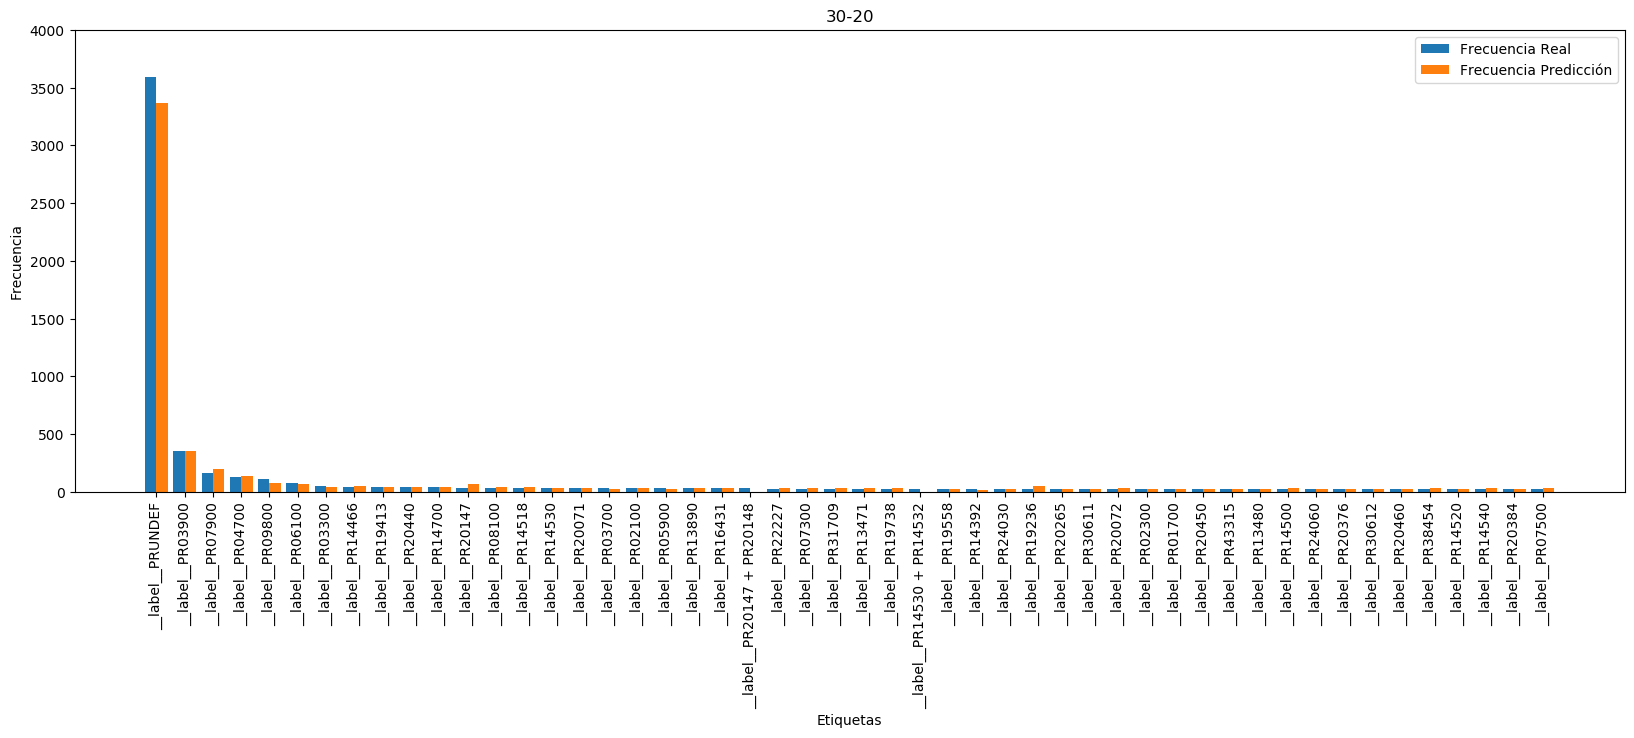

In [276]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(20, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('30-30')
plt.ylim(0, 4000)
plt.legend()
plt.show()

#### 30-35

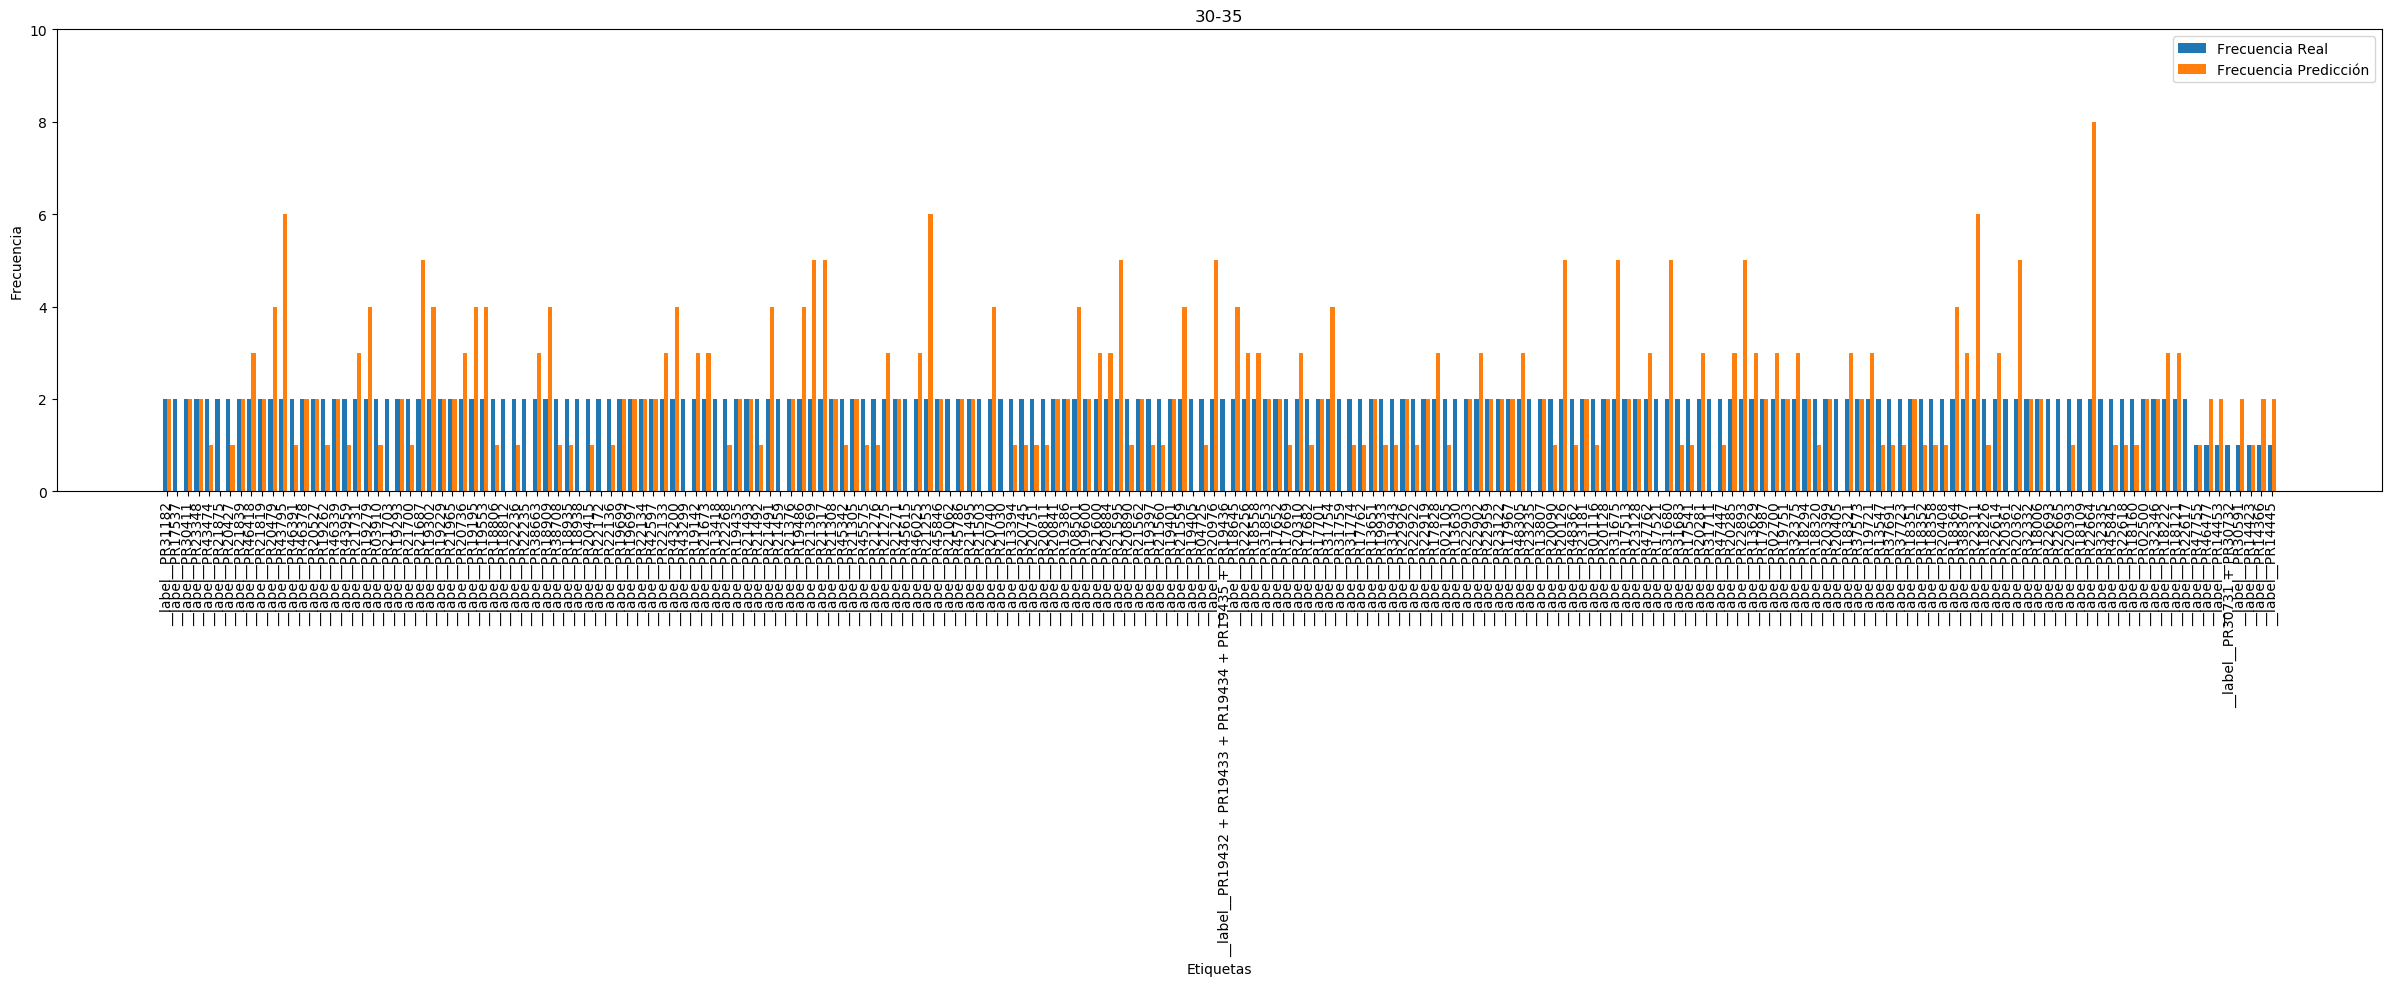

In [315]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][-500:-300]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][-500:-300]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(30, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('30-35')
plt.ylim(0, 10)
plt.legend()
plt.show()

#### 35-35

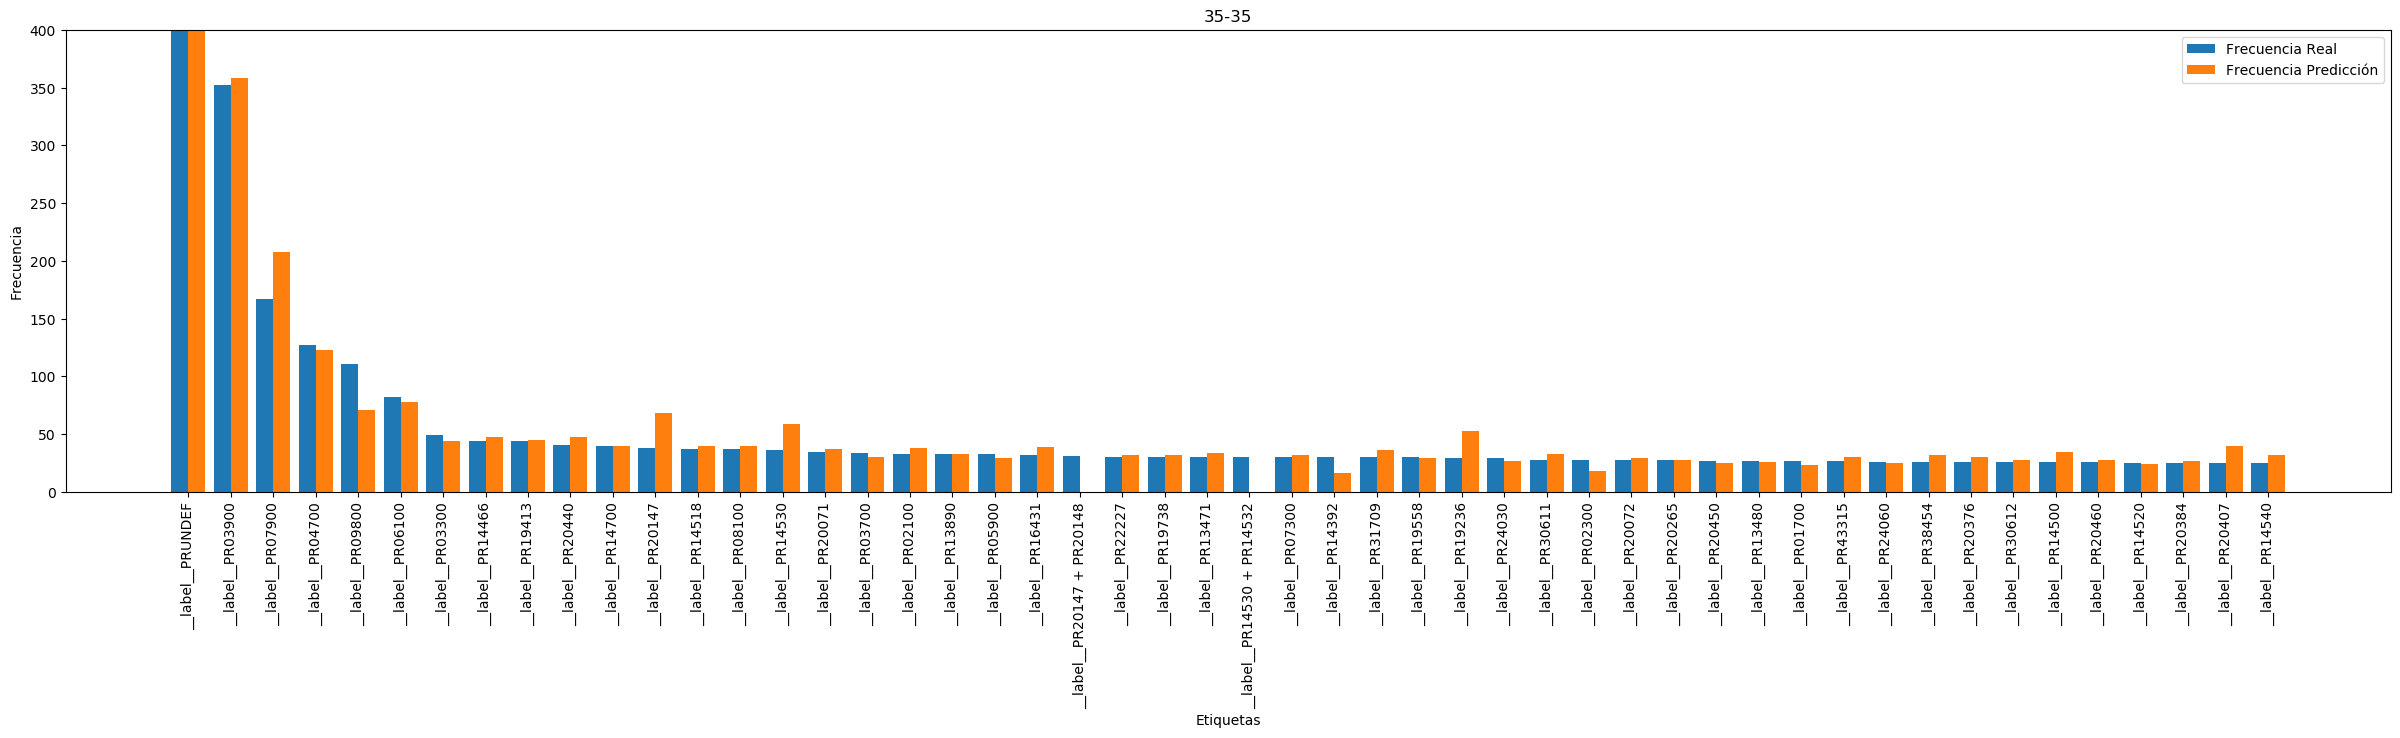

In [350]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:50]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(30, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('35-35')
plt.ylim(0, 400)
plt.legend()
plt.show()

#### CATEGORIA RARA HASTA 20 SIN MULTIPLES

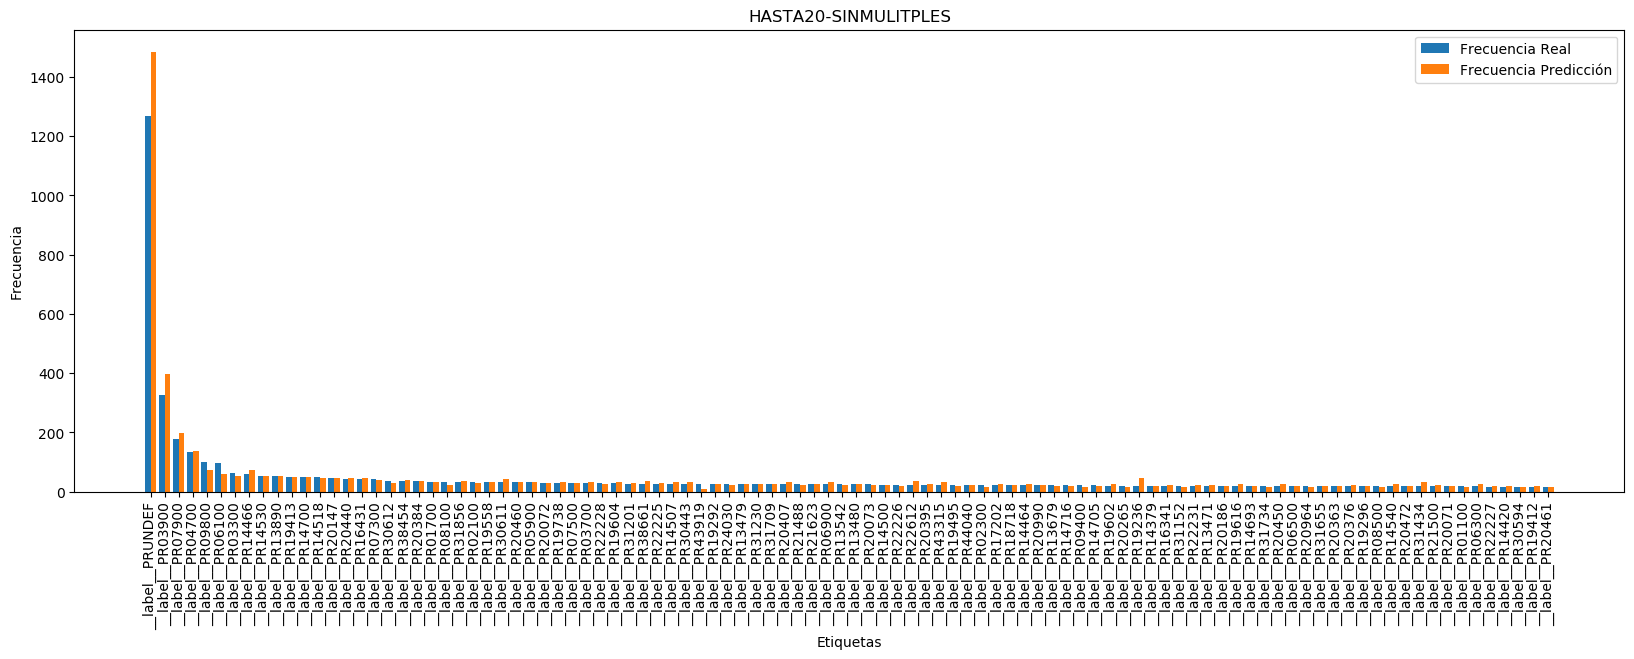

In [47]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
import numpy as np
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:100]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][:100]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(20, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('HASTA20-SINMULITPLES')
#plt.ylim(0, 400)
plt.legend()
plt.show()

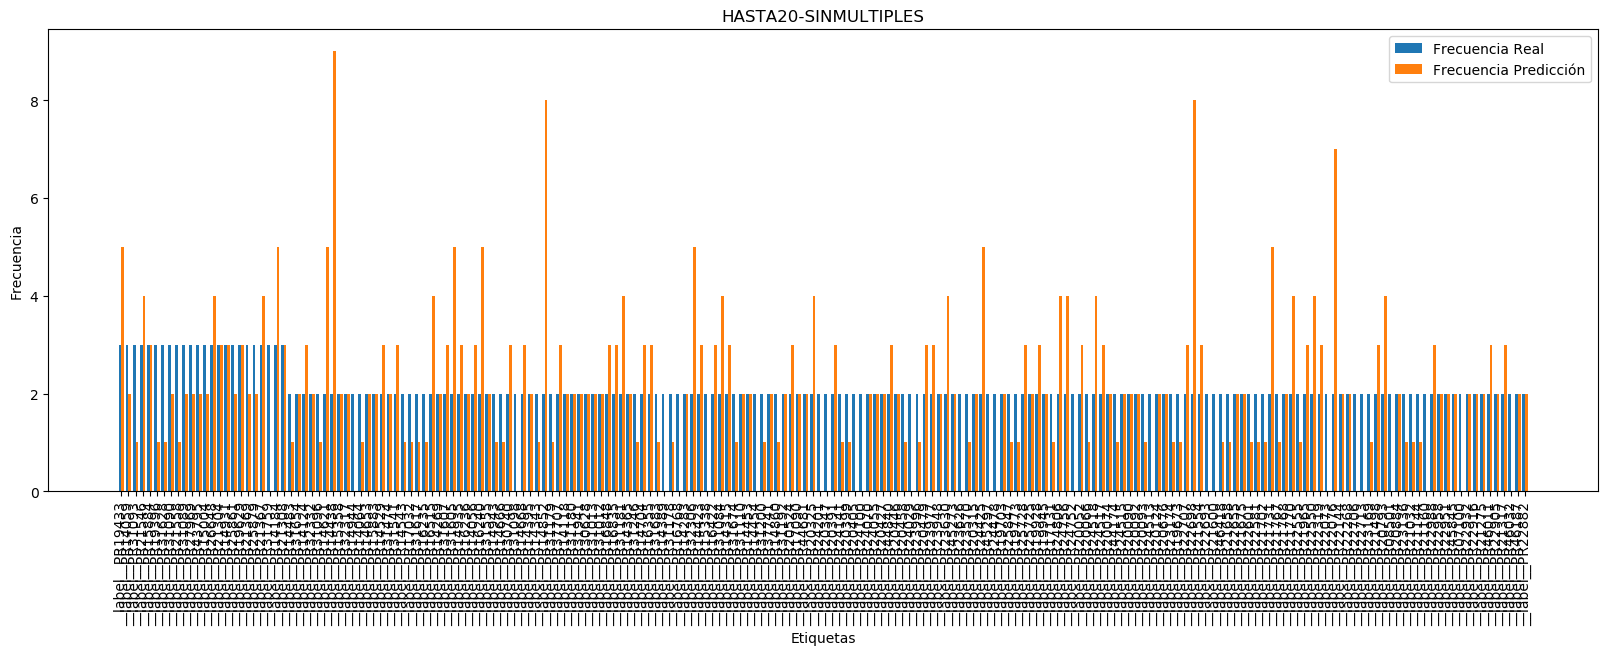

In [45]:
# Calcular las frecuencias de las etiquetas en el conjunto de test
frecuencias_etiquetas_reales = np.unique(etiquetas_reales, return_counts=True)

# Obtener las etiquetas más representativas
etiquetas_mas_representativas = frecuencias_etiquetas_reales[0][np.argsort(frecuencias_etiquetas_reales[1])[::-1][-500:-300]]
frecuencias_etiquetas_reales_mas_representativas = frecuencias_etiquetas_reales[1][np.argsort(frecuencias_etiquetas_reales[1])[::-1][-500:-300]]

# Filtrar las etiquetas predichas para mantener solo las que están presentes en las etiquetas más representativas
etiquetas_predichas_filtradas = [etiqueta_predicha for etiqueta_predicha in etiquetas_predichas if etiqueta_predicha in etiquetas_mas_representativas]
frecuencias_etiquetas_predichas = [etiquetas_predichas_filtradas.count(etiqueta) for etiqueta in etiquetas_mas_representativas]

# Crear un histograma con ambas barras
plt.figure(figsize=(20, 6))
plt.bar(np.arange(len(etiquetas_mas_representativas))-0.2, frecuencias_etiquetas_reales_mas_representativas, width=0.4, align='center', label='Frecuencia Real')
plt.bar(np.arange(len(etiquetas_mas_representativas))+0.2, frecuencias_etiquetas_predichas, width=0.4, align='center', label='Frecuencia Predicción')
plt.xticks(np.arange(len(etiquetas_mas_representativas)), etiquetas_mas_representativas, rotation=90)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('HASTA20-SINMULTIPLES')
#plt.ylim(0, 400)
plt.legend()
plt.show()